In [39]:
import sys
sys.path.append("..")
from JetscapeFileGetter import JetscapeFileGetter
from glob import glob
import uproot as up
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# files = JetscapeFileGetter(config_path='../config')

# files_10 = files('is_lbt', True)('pt0',10)
# files_10 = lbt_files('pt0',10)

# for x in files_10:
    # print(x.length)

# print(lbt_files.files)


In [40]:

def lin_grow_bins(x0:float, x1:float, space0:float, space1:float):
    ''' get bins from x0 to x0, starting with bin size space0 and ending with approx space1'''
    def space_at_x(x):
        return space0 + (space1-space0) * (x-x0)/(x1-x0)

    edges = [x0]
    x = x0
    space = space0
    while x +space < x1:
        x += space
        edges.append(x)
        space = space_at_x(x)
    edges[-1] = x1
    return np.array(edges)


In [41]:
def get_fragfn_dict(file_name:str, norm_by_IP:bool=True, 
                    norm_by_widths=True, edges = lin_grow_bins(0,1.,0.02,0.2),
                    IP_cut=None):

    tree = up.open(file_name)['T']
    ak_arr = tree['truth_vec_cpt'].array()
    IP_pt = np.array(tree['IP_pt'].array())

    is_match = np.array(tree['matched_TtoR'].array())

    if IP_cut is not None:
        # print([len(is_match),len(IP_pt), type(is_match), type(IP_pt>IP_cut[0])])
        is_match = np.all((is_match, (IP_pt > IP_cut[0]), IP_pt < IP_cut[1]),axis=0)

    ak_pt = ak_arr[is_match]
    IP_pt = IP_pt[is_match]
    njets = len(ak_pt)

    if norm_by_IP:
        ak_pt = ak_pt / IP_pt

    flat_arr = ak.to_numpy(ak.flatten(ak_pt))
    counts = np.histogram(flat_arr, bins=edges)[0]
    cnt_err = np.sqrt(counts)

    counts = counts / njets
    cnt_err = cnt_err / njets

    if norm_by_widths:
        counts = counts / np.diff(edges)
        cnt_err = cnt_err / np.diff(edges)


    return {'counts':counts, 'cnt_err':cnt_err, 'mean':np.mean(flat_arr),'std':np.std(flat_arr), 'njets':njets,
            'edges':edges,'centers':(edges[:-1] + edges[1:]) / 2, 'IP_pt':IP_pt}



In [60]:
# plot the data
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator, LogLocator

def plot_fragfn(config_path='../config', pp=None, which='lbt', cut=('pt0',10), 
                file_type='root', y_range=[1e-3,2e4], yrat_range=[0.007,30], lengths = None):
    files = JetscapeFileGetter(config_path=config_path, which=which, cut=cut, file_type=file_type)

    for file in files.files:
        print(file.file)


    fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [4, 4]}, )
    plt.subplots_adjust(hspace=0.0, left=0.20)
    colors = cm.viridis(np.linspace(0, 0.8, len(files.files)))

    if lengths is not None:
        colors = cm.viridis(np.linspace(0, 0.8, len(lengths)))


    # Plot each set of counts against centers
    first_dat = pp['counts']
    first_err = pp['cnt_err']
    first_relerrsq = (first_err/first_dat)**2

    axs[0].errorbar(pp['centers'], pp['counts'], yerr=pp['cnt_err'], fmt='s', color='gray', markersize=10, label=r'JETSCAPE $pp$')

    rat = pp['counts'] / first_dat
    rel_err = np.sqrt((pp['cnt_err']/pp['counts'])**2 + first_relerrsq)
    axs[1].errorbar(pp['centers'], rat, rat*rel_err, color='gray', fmt='s',
        markersize=10, label=r'JETSCAPE $pp$')

    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=16) 

    axs[0].yaxis.set_major_locator(MaxNLocator(nbins=8))
    # axs[0].set_yticks([0.01,0.1,0.001])#np.arange(0,1.1,0.01))
    i = -1
    for file in files:
        if lengths is not None:
            if file.length not in lengths:
                continue
        i+=1
        dat = get_fragfn_dict(file.file)
        # Assuming 'counts' is a list of counts and 'length' is the corresponding length
        # centers = np.arange(len(counts))  # replace with your actual centers if necessary
        msize=8.*(1-0.4*i/7.)
        print(f'size: {msize}')
        axs[0].errorbar(dat['centers'], dat['counts'], yerr=dat['cnt_err'], fmt='o',
                        color=colors[i], markersize=msize,
                    label=f'Brick {file.length:.0f} fm')
        # if i==0:
        #     # first_dat = dat['counts']
        #     # color='red'
        #     # rat = dat['counts'] / first_dat
        #     first_dat = dat['counts']
        #     first_err = dat['cnt_err']
        #     first_relerrsq = (first_err/first_dat)**2
        #     x = [dat['centers'][0],dat['centers'][-1]]
        #     y = [1,1]
        #     if False: 
        #         axs[1].plot(x, y, color='red', linestyle='-',
        #         label=f'Length {file.length:.0f} ave {dat["mean"]:.2g} std {dat["std"]:.2g}')
        color=colors[i]
        rat = dat['counts'] / first_dat
        rel_err = np.sqrt((dat['cnt_err']/dat['counts'])**2 + first_relerrsq)
        axs[1].errorbar(dat['centers'], rat, rat*rel_err, color=color, fmt='o',
                        markersize=msize,
            label=f'Brick {file.length:.0f} fm')

    axs[0]
    # axs[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left',fontsize=20)
    axs[0].set_ylabel(r'$\frac{1}{\mathrm{N}_\mathrm{jets}}\frac{\mathrm{dN}_\mathrm{part}}{\rm dz}$',fontsize=25)
    # axs[0].set_ylabel(r'$\frac{\mathrm{dN}_\mathrm{part}}{\rm dz}$',fontsize=20)
    axs[0].set_yscale('log')
    axs[0].set_ylim(y_range)
    axs[0].set_xlim((0,1))


    axs[1]
    # axs[1].set_yscale('log')
    axs[1].set_xlabel(r'$\mathrm{z}\equiv\frac{p_\mathrm{T}^\mathrm{part}}{p_\mathrm{T}^\mathrm{IP}}$',fontsize=21)
    axs[1].set_ylabel(r'Ratio to $pp$', fontsize=17)
    pt0 = int(files[0].pt0)
    pt1 = int(files[0].pt1)
    axs[0].set_title(r"$p_{\rm T,IP}\in$"+f'[{pt0},{pt1}]')
    axs[1].set_ylim(yrat_range)
    axs[0].set_xlim((0,1))
    # plt.show()

    return fig, axs, files


['../config/lbt_brick/gz_files/IP_match_trees/brick_2_maxT_20_nEv_5K_pT_30_31.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_12_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_1_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_12_maxT_20_nEv_5K_pT_30_31.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_14_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_4_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_8_maxT_20_nEv_5K_pT_30_31.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_9_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_10_maxT_20_nEv_5K_pT_20_21.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_10_maxT_20_nEv_5K_pT_40_41.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_10_maxT_20_nEv_5K_pT_30_31.root', '../config/lbt_brick/gz_files/IP_match_trees/brick_14_maxT_20_nEv_5K_

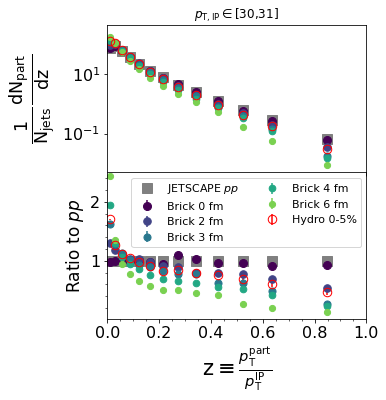

In [61]:
# Plot sub selection fo the pt0 30 data
msize=8.5

dat_ref_pp = get_fragfn_dict('../config/no_brick/gz_30_31/IP_match_trees/pthat_30_31.root')
fig, axs, l_files = plot_fragfn(which='lbt', pp=dat_ref_pp, cut=('pt0',30), file_type='root', lengths=(0,2,3,4,6), y_range=[5e-3,4.5e2],yrat_range=(0.015, 2.5))
# Plot sub selection fo the pt0 30 data
files = JetscapeFileGetter(config_path='../config',which='hydro',file_type='root',cut=('pt0',30))
print('fixme z0')
print(files.files[0].file)


# dat_ref = get_fragfn_dict(l_files.files[0].file)
dat_hydro = get_fragfn_dict(files.files[0].file)

# fig, axs = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
axs[0].errorbar(dat_hydro['centers'], dat_hydro['counts'], yerr=dat_hydro['cnt_err'], fmt='o', color='red',  markersize=msize,mfc='none',label=f'Hydro 0-5%')
# axs[1].legend()

rat_hydro = dat_hydro['counts'] / dat_ref_pp['counts']
rel_err = np.sqrt((dat_hydro['cnt_err']/dat_hydro['counts'])**2 + (dat_ref_pp['cnt_err']/dat_ref_pp['counts'])**2)
yerr = rat_hydro * rel_err
axs[1].errorbar(dat_hydro['centers'], rat_hydro, yerr=yerr, color='red', fmt='o', markersize=msize,mfc='none',label=f'Hydro 0-5%')

axs[1].legend(fontsize=11,ncol=2,bbox_to_anchor=(0.7, 0.7, .3,.3), loc='upper right')

fig.subplots_adjust(left=0.3,bottom=0.2)
axs[1].set_yscale('linear')

from matplotlib.ticker import AutoMinorLocator
# Set minor tick locators
axs[0].yaxis.set_minor_locator(LogLocator(base=10.0,  numticks=5))
axs[0].xaxis.set_minor_locator(AutoMinorLocator())
axs[1].xaxis.set_minor_locator(AutoMinorLocator())
# axs[1].yaxis.set_minor_locator(AutoMinorLocator())

# Customize tick parameters
# axs[0].tick_params(which='both', direction='in', top=True, right=True, length=6)
# axs[1].tick_params(which='both', direction='in', top=True, right=True, length=6)

axs[0].tick_params(labelbottom=False)
axs[0].minorticks_on()
axs[1].minorticks_on()

# axs[0].set_yticks([0.01, 0.1, 0.2,0.3])
plt.show()
fig.savefig('fragfn_lbt_hydro_pt0_30.pdf')

# plot_fragfn(which='lbt', cut=('pt0',30), file_type='root', lengths=(0,2,6,10,14), yrat_range=(0.01, 10))